<a href="https://colab.research.google.com/github/reinaldodamacena/Identify-Plant-Diseases-TensorFlow/blob/main/Identify_Plant_Diseases_%7C_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vipoooool_new_plant_diseases_dataset_path = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')

print('Data source import complete.')


In [ ]:
!nvidia-smi

Sun Nov 24 18:09:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Identificar doenças de plantas
Usamos o conjunto de dados PlantVillage [1] de Hughes et al. consiste em cerca de 87.000 imagens de folhas saudáveis ​​e não saudáveis, divididas em 38 categorias por espécie e doença. Aqui fornecemos um subconjunto de nossos experimentos sobre como trabalhar com esses dados. Acabamos também transferindo o aprendizado do MobileNet e usando os pesos do pré-treinamento no ImageNet.t.

* ![Amostras do conjunto de dados do PlantVillage](https://i.imgur.com/Zcxdrlc.png)
Figura 1. Amostras do conjunto de dados PlantVillage

## Aulas

As 38 classes a seguir estão disponíveis no conjunto de dados

- `Apple___Apple_scab`
- `Apple___Black_rot`
- `Apple___Cedar_apple_rust`
- `Apple___healthy`
- `Blueberry___healthy`
- `Cherry_(including_sour)___Powdery_mildew`
- `Cherry_(including_sour)___healthy`
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot`
- `Corn_(maize)___Common_rust_`
- `Corn_(maize)___Northern_Leaf_Blight`
- `Corn_(maize)___healthy', 'Grape___Black_rot`
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)`
- `Grape___healthy`
- `Orange___Haunglongbing_(Citrus_greening)`
- `Peach___Bacterial_spot`
- `Peach___healthy`
- `Pepper,_bell___Bacterial_spot`
- `Pepper,_bell___healthy`
- `Potato___Early_blight`
- `Potato___Late_blight`
- `Potato___healthy`
- `Raspberry___healthy`
- `Soybean___healthy`
- `Squash___Powdery_mildew`
- `Strawberry___Leaf_scorch`
- `Strawberry___healthy`
- `Tomato___Bacterial_spot`
- `Tomato___Late_blight`
- `Tomato___Leaf_Mold`
- `Tomato___Septoria_leaf_spot`
- `Tomato___Spider_mites Two-spotted_spider_mite`
- `Tomato___Target_Spot`
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus`
- `Tomato___Tomato_mosaic_virus`
- `Tomato___healthy`

##iaseferences

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from collections import Counter
import tensorflow.keras.backend as K
import cv2
import time


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import numpy as np

import os

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

## Obetenção de dados

Para aproveitar ao máximo nossos poucos exemplos de treinamento, iremos “aumentá-los” por meio de uma série de transformações aleatórias, para que nosso modelo nunca veja exatamente a mesma imagem duas vezes. Isso ajuda a evitar overfitting e ajuda o modelo a generalizar melhor.

No TensorFlow isso pode ser feito por meio da classe `tf.keras.preprocessing.image.ImageDataGenerator`. Esta classe permite que você:

- configure transformações aleatórias e operações de normalização a serem feitas em seus dados de imagem durante o treinamento
- instanciar geradores de lotes de imagens aumentadas (e seus rótulos) via `.flow(data, rótulos)` ou `.flow_from_directory(directory)`. Esses geradores podem então ser usados ​​com os métodos de modelo `tf.keras` que aceitam geradores de dados como entradas, `fit`, `evaluate` e `predict`.

In [ ]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

Fazemos os seguintes aumentos nas imagens:

- `width_shift` e `height_shift` são intervalos (como uma fração da largura ou altura total) dentro dos quais traduzir imagens aleatoriamente na vertical ou na horizontal
- `rescale` é um valor pelo qual multiplicaremos os dados antes de qualquer outro processamento. Nossas imagens originais consistem em coeficientes RGB de 0 a 255, mas esses valores seriam muito altos para serem processados ​​por nossos modelos (dada uma taxa de aprendizado típica), portanto, buscamos valores entre 0 e 1, escalando com 1/255. fator.
- `shear_range` serve para aplicar transformações de cisalhamento aleatoriamente
- `zoom_range` serve para ampliar aleatoriamente as imagens
- `fill_mode` é a estratégia usada para preencher pixels recém-criados, que podem aparecer após uma rotação ou mudança de largura/altura.

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Vamos preparar nossos dados. Usaremos `.flow_from_directory()` para gerar lotes de dados de imagem (e seus rótulos) diretamente de nossas imagens em suas respectivas pastas.

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.



## Crie um arquivo de índice de classes

Também queremos saber qual classe corresponde a quais espécies e doenças, então também criamos um arquivo `json` que mostra os rótulos e índices de classe correspondentes.

In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## Treinamento

Primeiro obtemos o modelo MobileNet básico sem incluir as camadas superiores, pois queremos usá-lo para 38 classes e usamos os pesos pré-treinados para ImageNet.

In [ ]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17227776/17225924 [==============================] - 1s 0us/step


Agora criamos um pequeno modelo upstream no MobileNet usando a API funcional

In [ ]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories),
                          activation="softmax")(x)

model = keras.Model(inputs = inputs,
                    outputs = x,
                    name="LeafDisease_MobileNet")


Em nossos vários experimentos, descobrimos que o otimizador Adam funciona muito bem com sua taxa de aprendizado padrão, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(),
                       'accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/25
150/150 [==============================] - 110s 710ms/step - loss: 2.8941 - categorical_accuracy: 0.2714 - accuracy: 0.2714 - val_loss: 0.8437 - val_categorical_accuracy: 0.7809 - val_accuracy: 0.7809
Epoch 2/25
150/150 [==============================] - 101s 674ms/step - loss: 0.8630 - categorical_accuracy: 0.7666 - accuracy: 0.7666 - val_loss: 0.5312 - val_categorical_accuracy: 0.8544 - val_accuracy: 0.8544
Epoch 3/25
150/150 [==============================] - 95s 635ms/step - loss: 0.5893 - categorical_accuracy: 0.8324 - accuracy: 0.8324 - val_loss: 0.3984 - val_categorical_accuracy: 0.8841 - val_accuracy: 0.8841
Epoch 4/25
150/150 [==============================] - 93s 623ms/step - loss: 0.4745 - categorical_accuracy: 0.8591 - accuracy: 0.8591 - val_loss: 0.3349 - val_categorical_accuracy: 0.8997 - val_accuracy: 0.8997
Epoch 5/25
150/150 [==============================] - 91s 606ms/step - loss: 0.4197 - categorical_accuracy: 0.8796 - accuracy: 0.8796 - val_loss: 0.2768 -

## Tempo de execução



In [ ]:
# Meça o tempo de inferência para uma amostra
start_time = time.time()
pred = model.predict(np.expand_dims(test_data[0][0][0], axis=0))
end_time = time.time()

print(f"Tempo de inferência para uma imagem: {end_time - start_time:.4f} segundos")

Tempo de inferência para uma imagem: 0.5876 segundos


## Estrutura do modelo


In [ ]:
model.summary()

Model: "LeafDisease_MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                38950     
Total params: 3,267,814
Trainable params: 38,950
Non-trainable params: 3,228,864
_________________________________________________________________


## Acessar Camadas

acessar as camadas internas do mobilenet_1.00_224.

In [ ]:
# Obter as camadas internas do bloco MobileNet
for layer in model.get_layer("mobilenet_1.00_224").layers:
    print(f"Layer name: {layer.name}, Output shape: {layer.output_shape}")


Layer name: input_1, Output shape: [(None, 224, 224, 3)]
Layer name: conv1, Output shape: (None, 112, 112, 32)
Layer name: conv1_bn, Output shape: (None, 112, 112, 32)
Layer name: conv1_relu, Output shape: (None, 112, 112, 32)
Layer name: conv_dw_1, Output shape: (None, 112, 112, 32)
Layer name: conv_dw_1_bn, Output shape: (None, 112, 112, 32)
Layer name: conv_dw_1_relu, Output shape: (None, 112, 112, 32)
Layer name: conv_pw_1, Output shape: (None, 112, 112, 64)
Layer name: conv_pw_1_bn, Output shape: (None, 112, 112, 64)
Layer name: conv_pw_1_relu, Output shape: (None, 112, 112, 64)
Layer name: conv_pad_2, Output shape: (None, 113, 113, 64)
Layer name: conv_dw_2, Output shape: (None, 56, 56, 64)
Layer name: conv_dw_2_bn, Output shape: (None, 56, 56, 64)
Layer name: conv_dw_2_relu, Output shape: (None, 56, 56, 64)
Layer name: conv_pw_2, Output shape: (None, 56, 56, 128)
Layer name: conv_pw_2_bn, Output shape: (None, 56, 56, 128)
Layer name: conv_pw_2_relu, Output shape: (None, 56, 56, 

## Review the training process

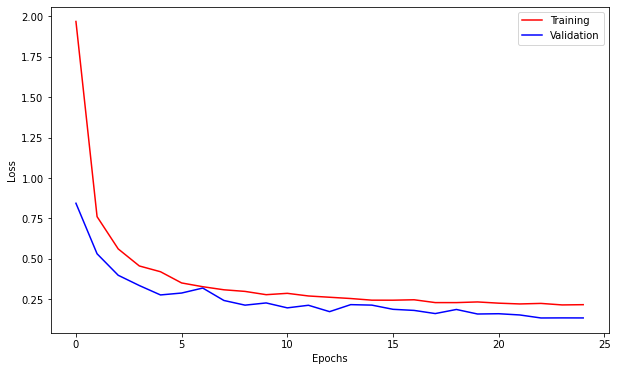

In [ ]:
###### loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

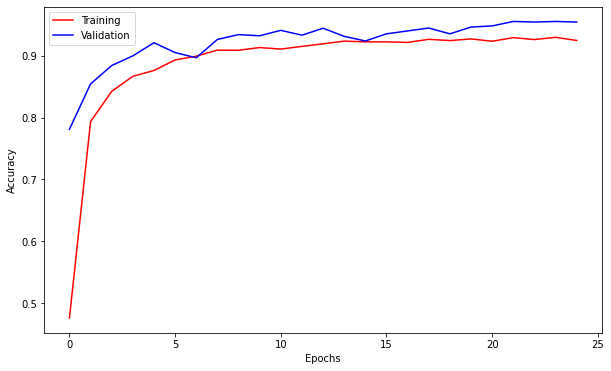

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model

We finally save the model in the standard TensorFlow 2 SavedModel format.

In [ ]:
model.save('plant_disease')

In [ ]:
##Exploração do Dataset

Visualize algumas amostras do dataset para verificar sua qualidade e diversidade.

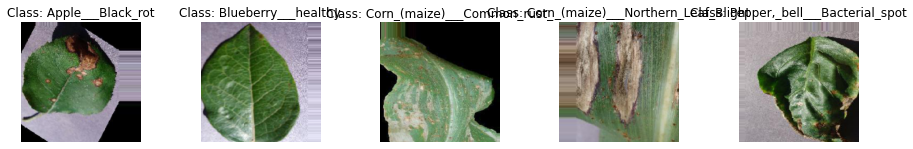

In [ ]:
def plot_sample_images(data_generator, class_names, n_samples=5):
    # Obtenha um lote de dados do gerador
    images, labels = next(data_generator)

    # Crie a figura
    plt.figure(figsize=(15, 8))

    # Exiba n_samples imagens do lote
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i])  # Exibe a i-ésima imagem do lote
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis("off")

    # Ajuste o espaçamento entre os subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.3)  # wspace controla o espaço horizontal, hspace o vertical
    plt.show()

# Obtenha os nomes das classes
class_names = list(train_data.class_indices.keys())

# Visualize as imagens com maior espaçamento
plot_sample_images(train_data, class_names, n_samples=5)


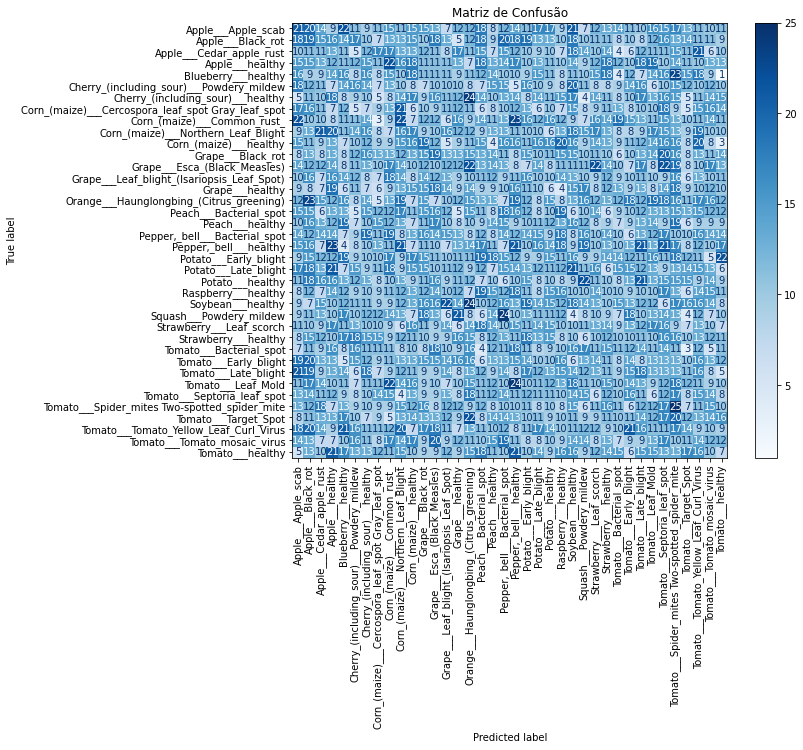

In [ ]:
def plot_confusion_matrix(model, data_generator, class_names):
    # Obtenha as predições do modelo
    y_pred = model.predict(data_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Classes previstas
    y_true = data_generator.classes  # Classes reais

    # Gere a matriz de confusão
    cm = confusion_matrix(y_true, y_pred_classes)

    # Exiba a matriz de confusão usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
    plt.title("Matriz de Confusão")
    plt.show()

# Exemplo de uso:
class_names = list(train_data.class_indices.keys())  # Obtenha os nomes das classes
plot_confusion_matrix(model, test_data, class_names)

## Imagens Classificadas Corretamente
Apresente imagens classificadas corretamente pelo modelo. Isso mostra como ele consegue identificar as características visuais associadas às classes.

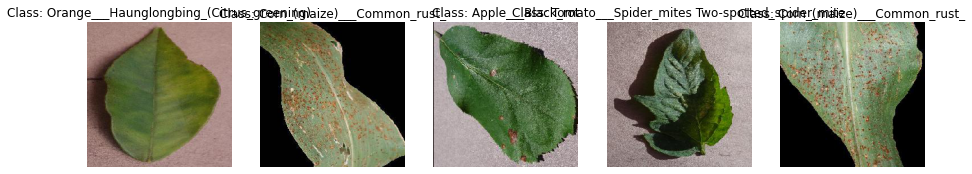

In [ ]:
def plot_correct_predictions(model, data_generator, class_names, n_samples=5):
    images, labels = next(data_generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    correct_indices = np.where(predicted_classes == true_classes)[0]

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(correct_indices[:n_samples]):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {class_names[true_classes[idx]]}")
        plt.axis("off")
    plt.show()

# Exemplo de uso:
plot_correct_predictions(model, test_data, class_names, n_samples=5)


## Imagens Mal Classificadas

magens onde o modelo errou, indicando a classe real e a classe prevista. Isso ajuda a identificar padrões visuais que levam a confusões

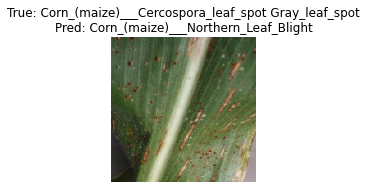

In [ ]:
def plot_incorrect_predictions(model, data_generator, class_names, n_samples=5):
    images, labels = next(data_generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    incorrect_indices = np.where(predicted_classes != true_classes)[0]

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(incorrect_indices[:n_samples]):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_classes[idx]]}\nPred: {class_names[predicted_classes[idx]]}")
        plt.axis("off")
    plt.show()

# Exemplo de uso:
plot_incorrect_predictions(model, test_data, class_names, n_samples=5)


In [ ]:
## Distribuição de Predições

gráfico de barras para mostrar como o modelo distribuiu suas predições para cada classe, comparando com a distribuição real.

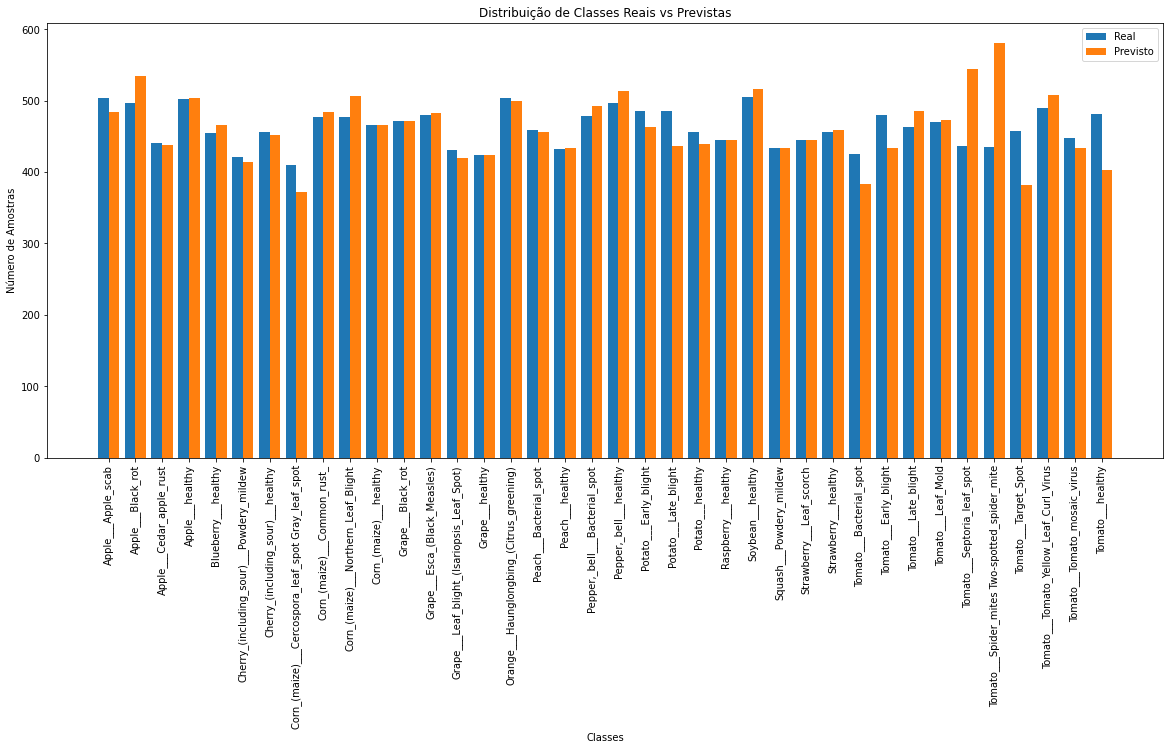

In [ ]:
# Contagem de classes reais e previstas
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

real_counts = Counter(y_true)
predicted_counts = Counter(y_pred_classes)

# Convertendo para listas
real = [real_counts[i] for i in range(len(class_names))]
predicted = [predicted_counts[i] for i in range(len(class_names))]

# Gráfico de barras
x = np.arange(len(class_names))

plt.figure(figsize=(20, 8))
plt.bar(x - 0.2, real, width=0.4, label='Real')
plt.bar(x + 0.2, predicted, width=0.4, label='Previsto')
plt.xticks(x, class_names, rotation='vertical')
plt.xlabel("Classes")
plt.ylabel("Número de Amostras")
plt.title("Distribuição de Classes Reais vs Previstas")
plt.legend()
plt.show()

##  Curvas ROC e AUC por Classe

As curvas ROC (Receiver Operating Characteristic) e a métrica AUC (Area Under Curve) mostram o desempenho do modelo para cada classe.

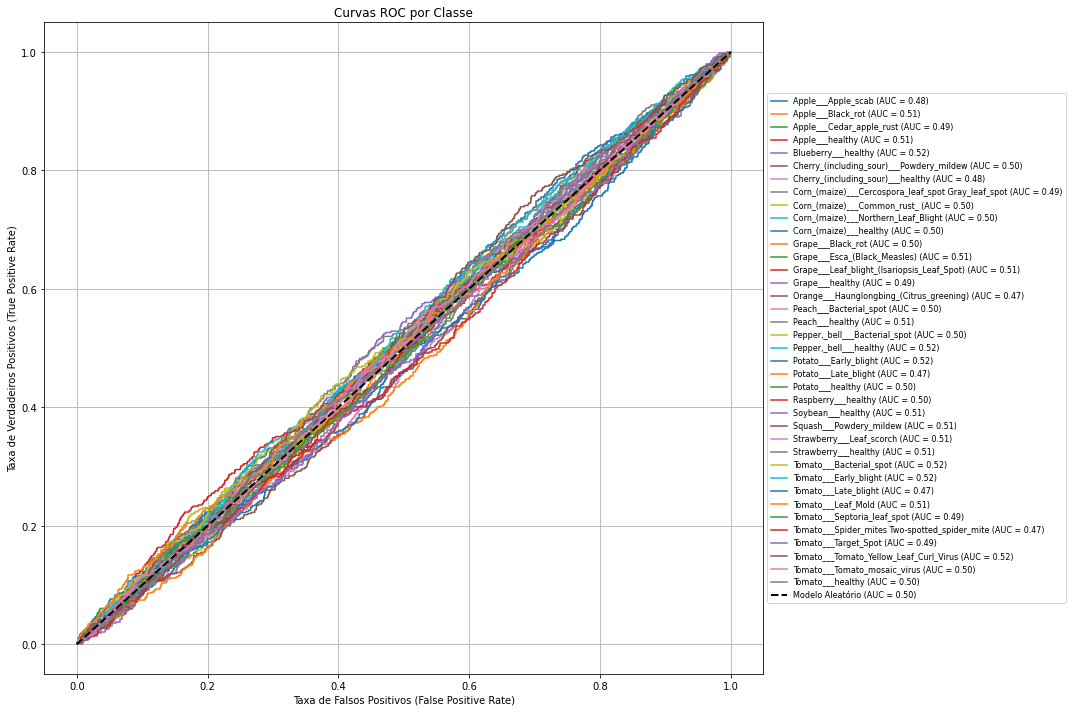

In [ ]:
# Função para gerar e plotar as Curvas ROC
def plot_roc_curves(model, data_generator, class_names):
    # Binarizar as classes reais
    y_true = data_generator.classes
    y_true_binary = label_binarize(y_true, classes=list(range(len(class_names))))

    # Obter as probabilidades previstas
    y_pred = model.predict(data_generator)

    # Configurar o gráfico
    plt.figure(figsize=(15, 10))
    plt.title("Curvas ROC por Classe")

    # Plotar a curva ROC para cada classe
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    # Linha diagonal indicando um modelo aleatório
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Modelo Aleatório (AUC = 0.50)")

    # Personalizar o gráfico
    plt.xlabel("Taxa de Falsos Positivos (False Positive Rate)")
    plt.ylabel("Taxa de Verdadeiros Positivos (True Positive Rate)")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)  # Ajustar posição da legenda
    plt.grid()
    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()

# Exemplo de uso
class_names = list(test_data.class_indices.keys())  # Obtenha os nomes das classes
plot_roc_curves(model, test_data, class_names)